# Microsoft Movie Studios Recommendations

![Microsoft Movie Studios](./Logo.png)

<h2>Overview

In this project we will help guide the executives at the newly founded Microsoft Movie Studios. We will analyze the <a href="www.imdb.com">IMDb</a>, <a href="https://www.rottentomatoes.com/">Rotten Tomatoes</a>, and <a href="https://www.boxofficemojo.com/">Box Office Mojo</a> datasets. We can use this information to make suggestions regarding the next steps regarding the creation of our first films, as well as potential acquisition decisions.

The first project our studio publishes will have major ramifications for our reputation both within the industry and without.
It's important for our future success to ensure our debut makes a major splash. 

<h2> Data Preparation

IMDb is the internet's movie largest database. We're interested in their data on Film Ratings, Films, and the Actors, Directors, Writers, and Producers involved in their creation.

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import sqlite3
from matplotlib import pyplot as plt
from matplotlib.ticker import StrMethodFormatter
%matplotlib inline
# Create connection and cursor objects to execute our SQLite queries
conn = sqlite3.connect("data/im.db")
cursor = conn.cursor()

In [3]:
q = "SELECT name FROM sqlite_master WHERE type='table';"
cursor.execute(q)
tables = cursor.fetchall()
table_names = [table[0] for table in tables]

In [4]:
# We now code loops through the table_names variable, and creates a variable with that name whose 
# value is the DataFrame associated with that table. It then appends these DataFrames to the list db
db = []
for t in table_names:
    vars().__setitem__(t, pd.read_sql(f"""
        SELECT *
        FROM {t}
        """, conn))
    db.append(vars()[t])

Let's first get an idea of the size, shape, columns, and datatypes within this database in order to inform further analysis

In [5]:
for x in range(len(db)):
    print(f"{table_names[x]}:")
    print(db[x].info())
    print()

movie_basics:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146144 non-null  int64  
 4   runtime_minutes  114405 non-null  float64
 5   genres           140736 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB
None

directors:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291174 entries, 0 to 291173
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   movie_id   291174 non-null  object
 1   person_id  291174 non-null  object
dtypes: object(2)
memory usage: 4.4+ MB
None

known_for:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1638260 entries, 0 to 1638259
Data columns (

It's clear that much of this data will be unhelpful in our analysis, and that much if it is redundant. For example, directors, writers, and known_for tables contain information that is duplicated in the principals table.



For this reason, we'll be focusing on combining `primary_name`s from the `persons` table with their `category` and `movie_id` from the `principals` table.


Let's look a little closer at the movie_akas table.

As a new studio, it's  important for us to garner a positive reputation by creating our own original films. Therefore, we can eliminate analysis on data involving non-original films.

In [6]:
movie_akas_originals = movie_akas.loc[movie_akas['is_original_title'] == 1.0]
movie_akas_originals.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44700 entries, 38 to 331700
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   movie_id           44700 non-null  object 
 1   ordering           44700 non-null  int64  
 2   title              44700 non-null  object 
 3   region             6 non-null      object 
 4   language           4 non-null      object 
 5   types              44700 non-null  object 
 6   attributes         0 non-null      object 
 7   is_original_title  44700 non-null  float64
dtypes: float64(1), int64(1), object(6)
memory usage: 3.1+ MB


We see that nearly all the data within the `region`, `language`, and `attributes` columns are null. The `ordering`, `types`, and `is_original_title` columns are all redundant now as well. We drop these columns and name the resulting table `originals`

In [7]:
originals = movie_akas_originals.drop(labels=['region', 'language', 'attributes', 'is_original_title', 'types', 'ordering'], axis=1)

Now that we have the original movies, let's join them with the `movie_basics` and `movie_ratings` tables, in order to have the `title`, `start_year`, `runtime_minutes`, and `genres` columns from `movie_basics`, and `averagerating` and `numvotes` columns from `movie_ratings`.

In [8]:
originals = originals.set_index('movie_id')
movie_basics = movie_basics.set_index('movie_id')
movie_ratings = movie_ratings.set_index('movie_id')

In [9]:
originals = originals.join(movie_basics, how='inner', rsuffix='_mb')
originals = originals.join(movie_ratings, how='inner', rsuffix='_mb')
originals.drop(labels=['primary_title', 'original_title'], axis=1, inplace=True)
originals = originals.reset_index()

In [10]:
originals.head()

,movie_id,title,start_year,runtime_minutes,genres,averagerating,numvotes
0,tt0063540,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77
1,tt0066787,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",7.2,43
2,tt0069049,The Other Side of the Wind,2018,122.0,Drama,6.9,4517
3,tt0069204,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",6.1,13
4,tt0100275,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy",6.5,119


Let's filter this table for a minimum of 500k `numvotes`, and sort by `averagerating`, as a sanity check.

In [11]:
originals.loc[(originals['numvotes'] >= 500000)].sort_values('averagerating', ascending=False).head()

,movie_id,title,start_year,runtime_minutes,genres,averagerating,numvotes
1556,tt1375666,Inception,2010,148.0,"Action,Adventure,Sci-Fi",8.8,1841066
206,tt0816692,Interstellar,2014,169.0,"Adventure,Drama,Sci-Fi",8.6,1299334
22558,tt4154756,Avengers: Infinity War,2018,149.0,"Action,Adventure,Sci-Fi",8.5,670926
4404,tt1675434,Intouchables,2011,112.0,"Biography,Comedy,Drama",8.5,677343
14124,tt2582802,Whiplash,2014,106.0,"Drama,Music",8.5,616916


Now let's look at the principals table

In [12]:
principals.head()

,movie_id,ordering,person_id,category,job,characters
0,tt0111414,1,nm0246005,actor,None,"[""The Man""]"
1,tt0111414,2,nm0398271,director,None,None
2,tt0111414,3,nm3739909,producer,producer,None
3,tt0323808,10,nm0059247,editor,None,None
4,tt0323808,1,nm3579312,actress,None,"[""Beth Boothby""]"


In [13]:
principals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1028186 entries, 0 to 1028185
Data columns (total 6 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   movie_id    1028186 non-null  object
 1   ordering    1028186 non-null  int64 
 2   person_id   1028186 non-null  object
 3   category    1028186 non-null  object
 4   job         177684 non-null   object
 5   characters  393360 non-null   object
dtypes: int64(1), object(5)
memory usage: 47.1+ MB


We'll now limit the rows of this table to contain only those which pertain to an original movie, as denoted by the `movie_id` within our originals DataFrame. We can then join the resulting table with the `persons` and `movie_ratings` tables to obtain the names of the individuals, as well as the the ratings of their work.

In [14]:
originals_movie_ids = list(originals['movie_id'])
principals_bool = [movie_id in originals_movie_ids for movie_id in principals['movie_id']]
principals_in_orig = principals.loc[principals_bool]

In [15]:
principals_names = principals_in_orig.set_index('person_id').join(persons.set_index('person_id'), how='inner')
principals_names = principals_names.reset_index()
prin_names_ratings = principals_names.set_index('movie_id').join(movie_ratings, how='inner')
prin_names_ratings = prin_names_ratings.reset_index()

We'll now define a function to parse the `prin_names_ratings` by `category` column, to separate the roles of the individuals into actors, actresses, directors, writers, producers, and composers. The function will then average the rating and number of votes of their work, as well as create a new column for the sum of the number of votes on all of their work. We can use this information to draw conclusions about how best to cast roles for our first films

In [16]:
def create_top_tables(srole, source):
    """
    INPUT:
    This function is taking in a list of strings, and a cleaned principals table.
    The list of strings are values from the roles within the Persons Table, Category Column, which we are interested in. 
    The Principals table has already been cleaned to have non-original works and unncessary columns removed.
    
    OUTPUT:
    Outputs a DataFrame whose variable name is the relevant role, ordered by total number of votes.
    """
    vars()[srole] = source.loc[source['category'] == srole].groupby('person_id').mean().sort_values(by='averagerating', ascending=False)
    vars()[srole]['total_numvotes'] = source.loc[source['category'] == srole].groupby('person_id').sum()['numvotes']
    vars()[srole] = vars()[srole].drop(['birth_year', 'ordering', 'death_year'], axis=1).join(persons.set_index('person_id'), how='inner').drop(labels='death_year', axis=1).rename(columns={'numvotes': 'avg_numvotes'})
    vars()[srole] = vars()[srole].loc[vars()[srole]['avg_numvotes'] >= 200000].sort_values('total_numvotes', ascending=False)
    vars()[srole]['avg_numvotes'] = vars()[srole]['avg_numvotes'].astype('int64')
    return vars()[srole]

In [17]:
roles = ["actor", "actress", "director", "writer", "producer", "composer"]
for i in range(len(roles)):
    vars()[roles[i]] = create_top_tables(roles[i], prin_names_ratings)

Let's do a `.head()` on one of the resulting tables as a sanity check.

In [18]:
actor.head()

,averagerating,avg_numvotes,total_numvotes,primary_name,birth_year,primary_profession
person_id,,,,,,
nm0000375,7.530769,488930,6356093,Robert Downey Jr.,1965.0,"actor,producer,soundtrack"
nm0000138,8.088889,697068,6273617,Leonardo DiCaprio,1974.0,"actor,producer,writer"
nm0262635,7.266667,367209,5508138,Chris Evans,1981.0,"actor,producer,director"
nm0362766,7.361538,380252,4943284,Tom Hardy,1977.0,"actor,producer,writer"
nm1165110,6.933333,323257,4848858,Chris Hemsworth,1983.0,"actor,soundtrack,producer"


# 1. Budgets data cleaning

In [19]:
budgets = pd.read_csv("data/tn.movie_budgets.csv")
budgets.head()
budgets.shape
budgets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


In [20]:
budgets['production_budget'] = budgets['production_budget'].str.replace("$", "").str.replace(",", "").astype(int)
budgets['domestic_gross'] = budgets['domestic_gross'].str.replace("$", "").str.replace(",", "").astype(int)
budgets['worldwide_gross'] = budgets['worldwide_gross'].str.replace("$", "").str.replace(",", "").astype('int64')
budgets['release_date'] = pd.to_datetime(budgets['release_date'])
budgets.head()
budgets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 5782 non-null   int64         
 1   release_date       5782 non-null   datetime64[ns]
 2   movie              5782 non-null   object        
 3   production_budget  5782 non-null   int32         
 4   domestic_gross     5782 non-null   int32         
 5   worldwide_gross    5782 non-null   int64         
dtypes: datetime64[ns](1), int32(2), int64(2), object(1)
memory usage: 226.0+ KB


# Comments on budgets data cleaning
The file tn.movie_budgets.csv is now cleaned, and the data types are all configured for further analysis. 

There could potentially be an issue in the future where we have an issue with the in32 and int64 datatypes of the last 3 columns. If that occurs we can modify the data types at that time.

# 2. Loading and cleaning bom.movie_gross

In [21]:
Bom = pd.read_csv("Data/bom.movie_gross.csv")

In [22]:
Bom.head()
Bom.info()
Bom.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


title                0
studio               5
domestic_gross      28
foreign_gross     1350
year                 0
dtype: int64

# Comments on values for BOM Movie Gross

- 5 missing values in studio. Will remove, since they're only 5 out of 3387.
- 28 missing values in domestic gross, will turn them all to 0. All str, will have to convert them to float, once all null's have been replaced with 0. Inspected them to make sure they were just foreign films.
- 1350 missing values in foreign gross (turn to 0), will turn them all to 0. All str, will have to convert them to float, once all null's have been replaced with 0. Domestic films that didn't have foreign gross. One has a comma, so have to take it out to normalize data.

In [23]:
Bom['foreign_gross'] = Bom['foreign_gross'].str.replace(',','')
Bom['foreign_gross'] = Bom['foreign_gross'].astype(float)
Bom['foreign_gross'] = Bom['foreign_gross'].fillna(0)
Bom['domestic_gross'] = Bom['domestic_gross'].fillna(0)
Bom = Bom.dropna(subset = ['studio'])

In [24]:
# Will create a new column, total_gross, to be able to compare the aggregate gross down the line.
Bom['total_gross'] = Bom['domestic_gross'] + Bom['foreign_gross']

In [25]:
#Upon trying to join (in an exploratory notebook) Bom dataframe with the budgets dataframe,
#we realized that we should change one of the 'domestic_gross' column name to be able to
#differentiate.
Bom.rename(columns={'domestic_gross':'domestic_gross_bom'},inplace=True)

In [26]:
Bom_titles = list(Bom['title'])
"""
We realized that in order to be able to give any sort of business advice we'd need to see
what these movies cost to make. Even though the budgets table has domestic and worldwide
gross, it does not have the studio that makes them. 

We will do a left join on the budgets dataframe with the movie titles as the overlap
column. In order to see which movie titles are in both dataframes we are creating a new 
column in budgets that returns True if the movie title overlaps. This is why
the above variable was created.

This overlap will allow us to dig deeper into what the investment return metrics for a succesful
movie studio look like. 

"""
def compare_title(title):
    if title in Bom_titles:
        return True
    else:
        return False
    
"""
The above function takes in a string, in this case a movie title, and returns true if that
string is in the provided Bom movie title list.

"""

'\nThe above function takes in a string, in this case a movie title, and returns true if that\nstring is in the provided Bom movie title list.\n\n'

In [27]:
budgets['Bom'] = budgets['movie'].map(compare_title)
budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,Bom
0,1,2009-12-18,Avatar,425000000,760507625,2776345279,False
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,True
2,3,2019-06-07,Dark Phoenix,350000000,42762350,149762350,False
3,4,2015-05-01,Avengers: Age of Ultron,330600000,459005868,1403013963,True
4,5,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,False


# 2.5 Left join bom to budgets

In [28]:
Bom_budg_ljn_on_title = budgets.join(Bom.set_index(['title']), on=['movie'])
"""
Below we're taking a look at all the movies that overlap in bom and budgets, and have a non
null value in the studio column.
"""
Bom_budg_ljn_on_title.loc[(Bom_budg_ljn_on_title['Bom']== True) & (Bom_budg_ljn_on_title['studio'] != Bom_budg_ljn_on_title['studio'].isna())]

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,Bom,studio,domestic_gross_bom,foreign_gross,year,total_gross
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,True,BV,241100000.0,804600000.0,2011.0,1.045700e+09
3,4,2015-05-01,Avengers: Age of Ultron,330600000,459005868,1403013963,True,BV,459000000.0,946400000.0,2015.0,1.405400e+09
6,7,2018-04-27,Avengers: Infinity War,300000000,678815482,2048134200,True,BV,678800000.0,1369.5,2018.0,6.788014e+08
8,9,2017-11-17,Justice League,300000000,229024295,655945209,True,WB,229000000.0,428900000.0,2017.0,6.579000e+08
9,10,2015-11-06,Spectre,300000000,200074175,879620923,True,Sony,200100000.0,680600000.0,2015.0,8.807000e+08
...,...,...,...,...,...,...,...,...,...,...,...,...
5667,68,2012-04-27,Sound of My Voice,135000,408015,429448,True,FoxS,408000.0,0.0,2012.0,4.080000e+05
5672,73,2012-06-15,Your Sister's Sister,120000,1597486,3090593,True,IFC,1600000.0,0.0,2012.0,1.600000e+06
5679,80,2015-07-10,The Gallows,100000,22764410,41656474,True,WB (NL),22800000.0,20200000.0,2015.0,4.300000e+07
5685,86,2017-07-07,A Ghost Story,100000,1594798,2769782,True,A24,1600000.0,0.0,2017.0,1.600000e+06


In [29]:
"""
Creating a separate dataframe to analyze each studio's worldwide total gross in usd, 
total production budget in usd, lifetime return in usd (which is calculated via
'worldwide total gross' - 'total production budget'), lifetime return as a % (which is
calculated via (('worldwide total gross' / 'total production budget')-1)), and the total
number of films per studio that these return metrics are based off of. Which in some cases
may be a very small sample of the total catalogue that studio has.

"""
studio_gross = Bom_budg_ljn_on_title.groupby('studio')['worldwide_gross'].sum().astype('int64')
studio_gross = pd.DataFrame(studio_gross)
studio_gross['total_production_budget'] = Bom_budg_ljn_on_title.groupby('studio')['production_budget'].sum().astype('int64')
studio_gross['$_lifetime_return'] = studio_gross['worldwide_gross'] - studio_gross['total_production_budget']
studio_gross['%_lifetime_return'] = (studio_gross['worldwide_gross']/studio_gross['total_production_budget']) - 1
studio_gross['#_of_films'] = Bom_budg_ljn_on_title.groupby('studio')['Bom'].sum().astype('int64')
studio_gross.reset_index(inplace=True)
studio_gross.describe()

,worldwide_gross,total_production_budget,$_lifetime_return,%_lifetime_return,#_of_films
count,9.900000e+01,9.900000e+01,9.900000e+01,99.000000,99.000000
mean,1.916135e+09,5.918551e+08,1.324280e+09,1.003176,12.585859
std,5.905648e+09,1.724612e+09,4.205917e+09,2.154181,23.758998
min,7.943000e+03,4.000000e+05,-9.009679e+07,-0.994725,1.000000
25%,5.686178e+06,8.650000e+06,-5.256492e+06,-0.499748,1.000000
50%,3.899229e+07,3.700000e+07,7.955193e+06,0.430914,2.000000
75%,3.925437e+08,1.716600e+08,2.452042e+08,2.094872,10.000000
max,3.328602e+10,9.450800e+09,2.383522e+10,13.319383,117.000000


In [30]:
"""
There appears to only be 1,246 movies that overlap. Want to see mean, median, and 75% IQR
for all values. Upon review, in order to give a recommendation on a studio we'll need to
narrow down our search to studios that have at least produced more than 10 (75% IQR) or
12 movies (mean). This will be our cutoff, so that we can't recommend a one hit wonder
studio or so to speak.
"""
studio_gross.loc[studio_gross['#_of_films'] > 10].sort_values('#_of_films',ascending=False)
studio_usd_sort = studio_gross.sort_values('$_lifetime_return',ascending=False)
studio_pct_sort = studio_gross.loc[studio_gross['#_of_films'] > 10].sort_values('%_lifetime_return',ascending=False)

# 3. Loading in and cleaning RT movie info

In [31]:
Rt = pd.read_csv('Data/rt.movie_info.tsv',sep = '\t')
Rt.head()
Rt.info()
Rt.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1560 entries, 0 to 1559
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            1560 non-null   int64 
 1   synopsis      1498 non-null   object
 2   rating        1557 non-null   object
 3   genre         1552 non-null   object
 4   director      1361 non-null   object
 5   writer        1111 non-null   object
 6   theater_date  1201 non-null   object
 7   dvd_date      1201 non-null   object
 8   currency      340 non-null    object
 9   box_office    340 non-null    object
 10  runtime       1530 non-null   object
 11  studio        494 non-null    object
dtypes: int64(1), object(11)
memory usage: 146.4+ KB


id                 0
synopsis          62
rating             3
genre              8
director         199
writer           449
theater_date     359
dvd_date         359
currency        1220
box_office      1220
runtime           30
studio          1066
dtype: int64

# Missing data comments
- synopsis, only missing 62 entries
- rating missing 3 entries
- genre missing 8 values, since our analysis in this section will be based upon genres we'll remove the nulls here. Removing them because they're a very small portion of the dataset.
- director, missing 199 entries
- writer, missing 449 entries
- theater_date, missing 359 entries
- dvd_date, missing 359 entries as well
- currency, missing 1210 entries
- box-office, missing 1210 entries as well.
- runtime, missing 20 entries
- studio, missing 1066 entries
- I don't have any move titles....

# Cleaning the RT dataframe
- Should condense genre, to a category | subcategory
- Should turn the dates to date value
- Should turn the box office number into an int or float
- Should standardize runtime into mins
- Will remove entries without synopsis as we won't be able to source movie title, and double checked that they do not have box office numbers either.

In [32]:
# Cleaning up the box office numbers from str to int
Rt['box_office'] = Rt['box_office'].str.replace(',','')

# Cleaning up the theater and dvd dates to datetime format.
Rt['theater_date'] = pd.to_datetime(Rt['theater_date'])
Rt['dvd_date'] = pd.to_datetime(Rt['dvd_date'])

# Findings on data exploration
Was going to remove the null synopsis entries, and try to match the movie titles in the
budgets CSV titles to the movie title in the synopsis string. Every synopsis mentions the title of the movie they're talking about at least once. The problem with trying to return the movie title string if it's in the synopsis is that for a single word or number movie title, it would return the wrong movie title. Example being 'her', the word her appears a myriad of times through a multitude of synopsis, which would lead to incorrect movie titles being assigned.

Rt = Rt.dropna(subset=['synopsis'])

In [33]:
"""
Decided to pivot from trying to join this dataframe with budgets, and now we are going to 
standardize the 'genre' format in order to produce an analysis based on 'genre' and 'fresh'
rating. Going to limit the 'genre' column to just the first two that currently show in 'genre'.
This will lower the unique genre's from 299 to 78.

We want to find out if there's a skew for certain genres, although more popular movies
in any genre will always skew a genre due to the number of ratings.
"""
def genre_condenser(genre):
    new_genre = genre.split(sep='|')
    try:
        if 'Classics' in new_genre:
            new_genre.remove('Classics')
            new_genre = f'{new_genre[0]}|{new_genre[1]}'
            return new_genre
        else:
            new_genre = f'{new_genre[0]}|{new_genre[1]}'
            return new_genre
    except:
        new_genre = f'{new_genre[0]}'
        return new_genre

#Dropping the Nan values associated with genre.
Rt = Rt.dropna(subset = ['genre'])
Rt['genre'] = Rt['genre'].map(genre_condenser)

# 2.5 Loading in the RT Reviews
- When at least 60% of reviews for a movie or TV show are positive, a red tomato is displayed to indicate its Fresh status.

- When less than 60% of reviews for a movie or TV show are positive, a green splat is displayed to indicate its Rotten status.

https://www.rottentomatoes.com/about

In [34]:
Rt_Reviews = pd.read_csv('Data/rt.reviews.tsv',delimiter='\t',encoding='cp850')
Rt_Reviews.info()
Rt_Reviews.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54432 entries, 0 to 54431
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          54432 non-null  int64 
 1   review      48869 non-null  object
 2   rating      40915 non-null  object
 3   fresh       54432 non-null  object
 4   critic      51710 non-null  object
 5   top_critic  54432 non-null  int64 
 6   publisher   54123 non-null  object
 7   date        54432 non-null  object
dtypes: int64(2), object(6)
memory usage: 3.3+ MB


id                0
review         5563
rating        13517
fresh             0
critic         2722
top_critic        0
publisher       309
date              0
dtype: int64

# Missing values
- review         5563
- rating        13517
- critic         2722
- publisher       309
- No missing values for 'fresh', which let's us fully exlpore our 'fresh' to 'genre'
    analysis.

In [35]:
#It appears that there are only 1135 unique movies according to the unique id count.
#So we have 425 less unique movies to compare. Total movies in the RT movie info is 1560.
Rt_Reviews['id'].value_counts()

782     338
1067    275
1525    262
1777    260
1083    260
       ... 
28        1
102       1
348       1
476       1
1727      1
Name: id, Length: 1135, dtype: int64

In [36]:
# In order to join, need to change the rating label col name for one of them.
# Upon joining it looks like we have five less genres. 78 to 73.
Rt_Reviews.rename(columns={'rating':'mov_rating'}, inplace=True)
Rt_id_left_join = Rt_Reviews.join(Rt.set_index(['id']), on=['id'])

In [37]:
"""
Want to see the average review amount per movie. One movie equals one genre type.
Here we see that on average each movie had 1,045 reviews, so that will be our cutoff to
analyze genres.

"""
Rt_id_left_join.describe()

,id,top_critic
count,54432.000000,54432.000000
mean,1045.706882,0.240594
std,586.657046,0.427448
min,3.000000,0.000000
25%,542.000000,0.000000
50%,1083.000000,0.000000
75%,1541.000000,0.000000
max,2000.000000,1.000000


In [38]:
"""
All the genres in the analysis will have at least 1,000 reviews. In order to understand if
a genre is fresh or not, we're creating two separate dataframes. One where all the reviews
are fresh and another where all the reviews are rotten. Then we're going to create a merged
dataframe where all the fresh and rotten reviews are counted by genre. In order to see
whether a genre is overall 'fresh' aka popular, we'll divide the 'fresh' count by the
'rotten' count per genre. If the ratio is positive then it's indicating that reviewers
find this genre more popular, but if it's negative it indicates that the genre is viewed as
a less desirable genre.

fresh ratio % = 'fresh'/'rotten'

"""

fresh_Rt_join = Rt_id_left_join.loc[Rt_id_left_join['fresh'] == 'fresh']
rotten_Rt_join = Rt_id_left_join.loc[Rt_id_left_join['fresh'] == 'rotten']

for_Rt_genre = fresh_Rt_join.groupby('genre')['fresh'].count()
for_Rt_genre = pd.DataFrame(for_Rt_genre)
for_Rt_genre['rotten'] = rotten_Rt_join.groupby('genre')['fresh'].count()
for_Rt_genre['rotten'].fillna(0, inplace = True)
for_Rt_genre['fresh_ratio_%'] = (for_Rt_genre['fresh'] / for_Rt_genre['rotten'])-1
for_Rt_genre['total_reviews'] = for_Rt_genre['fresh']+for_Rt_genre['rotten']
for_Rt_genre.reset_index(inplace=True)
for_Rt_genre_cutoff = for_Rt_genre.loc[for_Rt_genre['total_reviews'] >= 1000]
for_Rt_genre_cutoff = for_Rt_genre_cutoff.sort_values('total_reviews',ascending=False).head(10)
for_Rt_genre_cutoff = for_Rt_genre_cutoff.sort_values('fresh_ratio_%',ascending=False)

# 4. Loading in and cleaning tmdb.movies

In [39]:
tmdb = pd.read_csv('Data/tmdb.movies.csv')

In [40]:
#Dropping Unnamed: 0
#No missing values
tmdb.drop(columns=['Unnamed: 0'],inplace=True)
tmdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26517 entries, 0 to 26516
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   genre_ids          26517 non-null  object 
 1   id                 26517 non-null  int64  
 2   original_language  26517 non-null  object 
 3   original_title     26517 non-null  object 
 4   popularity         26517 non-null  float64
 5   release_date       26517 non-null  object 
 6   title              26517 non-null  object 
 7   vote_average       26517 non-null  float64
 8   vote_count         26517 non-null  int64  
dtypes: float64(2), int64(2), object(5)
memory usage: 1.8+ MB


In [41]:
#Getting rid of the empty genre_id entries, around 2000 entries eliminated from this. Have
#around 1000 genres, will deal with this below by creating a fucntion to map out the dataframe.
tmdb = tmdb.loc[tmdb['genre_ids'] != '[]']
tmdb['genre_ids'].value_counts()

[99]                         3700
[18]                         2268
[35]                         1660
[27]                         1145
[53]                          480
                             ... 
[878, 9648, 14]                 1
[28, 12, 35, 14, 878, 53]       1
[16, 10402, 18]                 1
[12, 28, 878, 10770]            1
[12, 14, 28, 10749]             1
Name: genre_ids, Length: 2476, dtype: int64

In [42]:
#TMDB genre ID tags https://www.themoviedb.org/talk/5daf6eb0ae36680011d7e6ee
#Created a dictionary, based on the id values found on the website!
tmdb_genres= {"28":"Action",
            "12":"Adventure",
            "16":"Animation",
            "35":"Comedy",
            "80":"Crime",
            "99":"Documentary",
            "18":"Drama",
            "10751":"Family",
            "14":"Fantasy",
            "36":"History",
            "27":"Horror",
            "10402":"Music",
            "9648":"Mystery",
            "10749":"Romance",
            "878":"Science Fiction",
            "10770":"TV Movie",
            "53":"Thriller",
            "10752":"War",
            "37":"Western"}

In [43]:
"""
Have around 1000 types of genres, in order to give a recommendation based on genres, will
need to cap the genre's per id. Tried capping it to three, but still gave us 595 unique genres.
Decided to cap it to two, which brings it down to 164 which is paletable for an analysis.

The function below takes in the str, which is a list of genre ids, and converts it to a
list of genre ids . Then once we have the list of ids it checks each id through the tmdb genre list
and adds the genre name to a blank list. If the genre name is already there then it will not
add it to the list again. The function then checks if the list of genre names is at two, and
if so it returns the string version of the genre name list.

Tested to make sure that genre names weren't coming out as double unique identifiers, ie
'Drama'|'Comedy' and 'Comedy'|'Drama'.

"""

def genre_id_conv(genre_list):
    genre_list = genre_list.replace('[','').replace(']','').split(sep=',')
    genre_name = []
    for key,val in tmdb_genres.items():
        for genre_id in genre_list:
            if key in genre_id:
                if val not in genre_name and len(genre_name) < 2:
                    genre_name.append(val)
    return str(genre_name)

tmdb['genre_names'] = tmdb['genre_ids'].map(genre_id_conv)

In [44]:
tmdb.describe()

,id,popularity,vote_average,vote_count
count,24038.000000,24038.000000,24038.000000,24038.000000
mean,292504.549671,3.375461,5.984208,214.047259
std,155419.517895,4.501957,1.780916,1007.213853
min,27.000000,0.600000,0.000000,1.000000
25%,148607.250000,0.635000,5.000000,2.000000
50%,307170.000000,1.494000,6.000000,6.000000
75%,419629.250000,4.424000,7.000000,34.000000
max,608079.000000,80.773000,10.000000,22186.000000


In [45]:
"""
We decided to not use this data as our qualitative analysis has led us to believe that
Rotten Tomatoes reviews are viewed as more important.

"""

'\nWe decided to not use this data as our qualitative analysis has led us to believe that\nRotten Tomatoes reviews are viewed as more important.\n\n'

<h2>Data Analysis

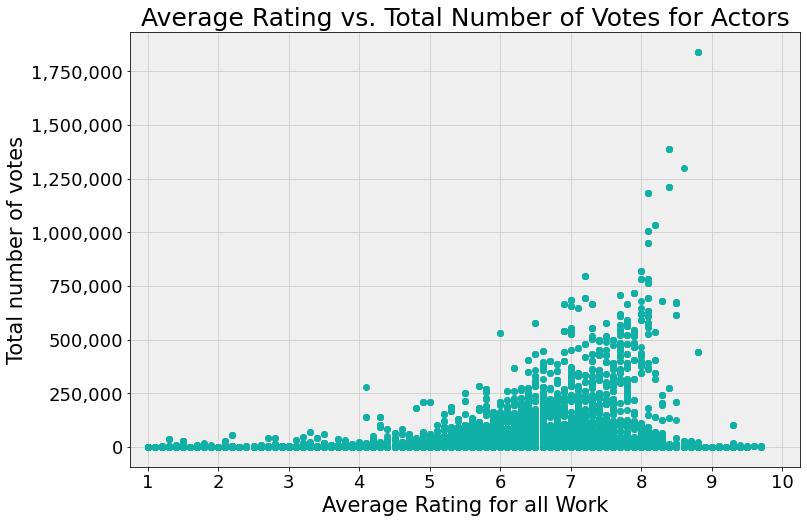

In [63]:
fig, ax = plt.subplots(figsize=(12,8))

labels = np.arange(1, 11, 1)

small_size, medium_size, large_size, xlarge_size = 14, 18, 21, 25
plt.rc('font', size=small_size)
plt.rc('axes', titlesize=xlarge_size)
plt.rc('axes', labelsize=large_size)
plt.rc('xtick', labelsize=medium_size)
plt.rc('ytick', labelsize=medium_size)
plt.grid(color="#cccccc")
fig.patch.set_facecolor('white')
plt.xlim([0.75,10.25])
ax.set_axisbelow(True)
ax.set_facecolor("#efefef")
plt.ticklabel_format(style='plain')
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

ax.scatter(prin_names_ratings.loc[prin_names_ratings['category'] == 'actor']['averagerating'],
           prin_names_ratings.loc[prin_names_ratings['category'] == 'actor']['numvotes'], c="#11b0a7")

ax.set_xlabel("Average Rating for all Work")
ax.set_ylabel("Total number of votes")
ax.set_title("Average Rating vs. Total Number of Votes for Actors")
ax.set_xticks(labels);
plt.savefig('VotesVsRating.png', dpi=1000);

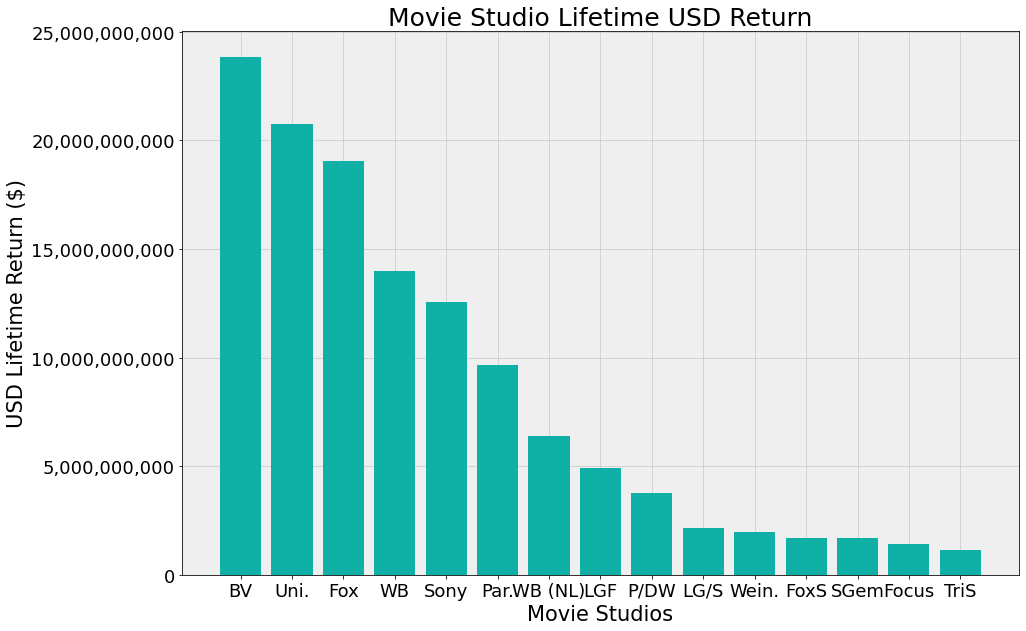

In [60]:
"""
1st plot is a bar chart showing in descending order the top 20 studios based on lifetime
return in usd.

"""
from matplotlib.ticker import StrMethodFormatter

fig, ax = plt.subplots(figsize=(15,10))
small_size, medium_size, large_size, xlarge_size = 14, 18, 21, 25
plt.rc('font', size=small_size)
plt.rc('axes', titlesize=xlarge_size)
plt.rc('axes', labelsize=large_size)
plt.rc('xtick', labelsize=medium_size)
plt.rc('ytick', labelsize=medium_size)
plt.ticklabel_format(style='plain')
plt.grid(color="#cccccc")
ax.set_axisbelow(True)
ax.set_facecolor("#efefef")
fig.patch.set_facecolor('white')

ax.bar(x=studio_usd_sort['studio'].head(15),height=studio_usd_sort['$_lifetime_return'].head(15), color="#11b0a7")
ax.set_xlabel('Movie Studios')
ax.set_ylabel('USD Lifetime Return ($)')
ax.set_title('Movie Studio Lifetime USD Return')
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.tight_layout;
plt.savefig('Movie_studio_usd.png', dpi=1000);

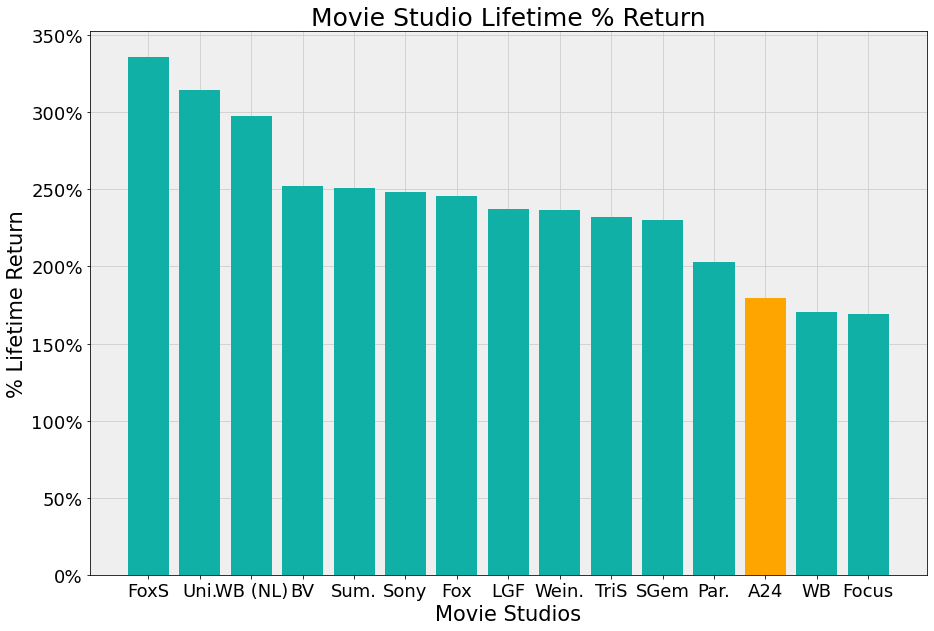

In [61]:
"""
2nd plot is a bar chart showing in descending order the top 20 studios based on lifetime
return as a %.
"""
fig, ax = plt.subplots(figsize=(15,10))
small_size, medium_size, large_size, xlarge_size = 14, 18, 21, 25
plt.rc('font', size=small_size)
plt.rc('axes', titlesize=xlarge_size)
plt.rc('axes', labelsize=large_size)
plt.rc('xtick', labelsize=medium_size)
plt.rc('ytick', labelsize=medium_size)
plt.grid(color="#cccccc")
fig.patch.set_facecolor('white')
ax.set_axisbelow(True)
ax.set_facecolor("#efefef")
colors = ["orange" if i == "A24" else "#11b0a7" for i in studio_pct_sort['studio'].head(15)]

ax.bar(x=studio_pct_sort['studio'].head(15),height=studio_pct_sort['%_lifetime_return'].head(15),color=colors)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
ax.set_xlabel('Movie Studios')
ax.set_ylabel('% Lifetime Return')
ax.set_title('Movie Studio Lifetime % Return')
plt.tight_layout
plt.savefig('Movie_studio_pct.png', dpi=1000);

<ipython-input-62-de48580ebcae>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels=for_Rt_genre_cutoff['genre'].head(10))


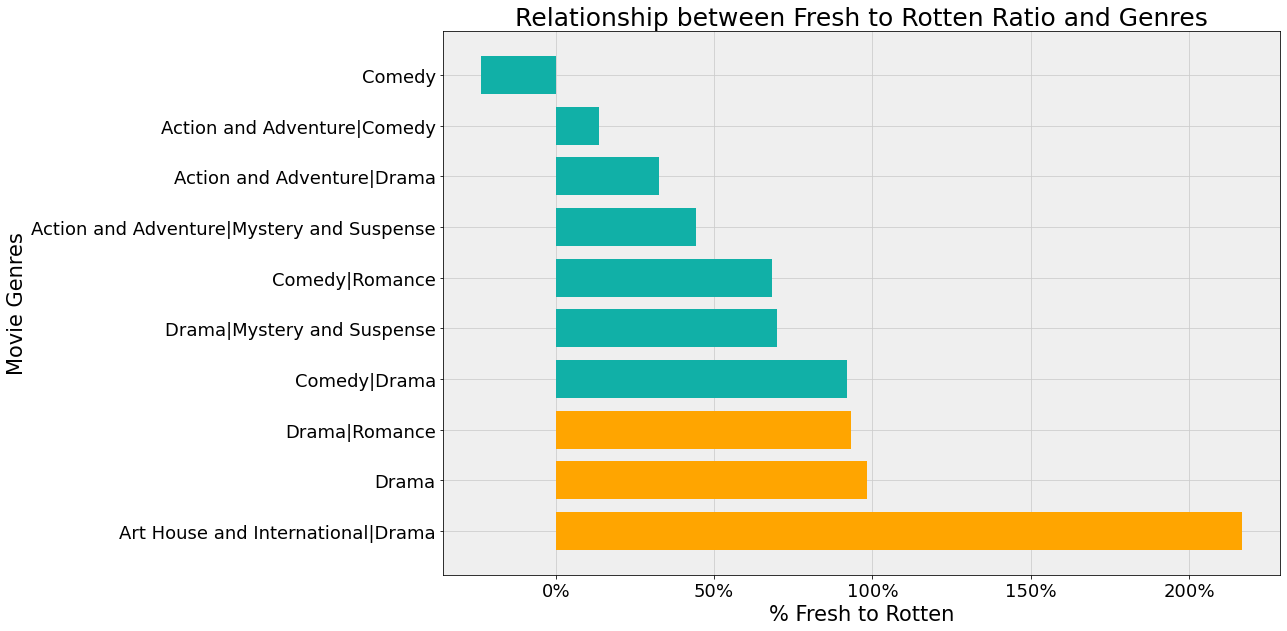

In [62]:
#Plot
import matplotlib.ticker as mtick
fig, ax = plt.subplots(figsize=(15,10))
small_size, medium_size, large_size, xlarge_size = 14, 18, 21, 25
plt.rc('font', size=small_size)
plt.rc('axes', titlesize=xlarge_size)
plt.rc('axes', labelsize=large_size)
plt.rc('xtick', labelsize=medium_size)
plt.rc('ytick', labelsize=medium_size)
plt.grid(color="#cccccc")
fig.patch.set_facecolor('white')
ax.set_axisbelow(True)
ax.set_facecolor("#efefef")
colors = ["orange" if i == "Drama" or i =="Art House and International|Drama" or i == "Drama|Romance"else "#11b0a7" for i in for_Rt_genre_cutoff['genre'].head(10)]

# ax.bar(x=for_Rt_genre_cutoff['genre'].head(10),height=for_Rt_genre_cutoff['fresh_ratio_%'].head(10),color=colors)
ax.barh(for_Rt_genre_cutoff['genre'].head(10), height=0.75, width=for_Rt_genre_cutoff['fresh_ratio_%'].head(10), color=colors)
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
ax.set_yticklabels(labels=for_Rt_genre_cutoff['genre'].head(10))
ax.set_ylabel('Movie Genres')
ax.set_xlabel('% Fresh to Rotten')
ax.set_title("Relationship between Fresh to Rotten Ratio and Genres")
plt.tight_layout
plt.savefig('Rt_fresh_rot.png', dpi=1000);

<h2> Conclusions

Casting
- Hire Cast & Crew with most popular history, as this will give the film potential access to more viewers by attracting the artists fan base.

Genres
- Make Dramas and Drama variants, as they appear to be viewed as favorably popular by reviewers.

Acquisitions
- Consider acquiring A24 to jumpstart production, they already have a great catalogue of movies and deep seeded relationships in the industry.


Using big names will enable us to enter the industry with a bang, ensuring our studio is known as a place where great films are made. Gathering praise from insiders and viewers alike.